In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Fri May  5 02:20:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers scipy ftfy accelerate
!pip install diffusers==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 9.6 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelWithLMHead, AdamW
from diffusers import StableDiffusionPipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from tqdm import tqdm
import torch

In [5]:
tokenizer = AutoTokenizer.from_pretrained('T5-base')
model = AutoModelWithLMHead.from_pretrained('T5-base', return_dict=True)

In [6]:
# Pipeline for stable diffusion(text to image)
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16) 

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# New section

In [7]:
data = pd.read_csv('./sample_data/CNN_news_data.csv')

In [8]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
train_data_X = list(train_data['article'])
train_data_y = list(train_data['highlights'])

In [10]:
test_data_X = list(test_data['article'])
test_data_y = list(test_data['highlights'])

In [11]:
# Tokenize the training data
train_input_ids = tokenizer.batch_encode_plus(train_data_X, return_tensors='pt', padding=True)['input_ids']
train_output_ids = tokenizer.batch_encode_plus(train_data_y, return_tensors='pt', padding=True)['input_ids']


In [12]:
len(train_data_X)

800

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Fine-tune the model
optimizer = AdamW(model.parameters(), lr=3e-5)
for epoch in range(1):
    for i in  tqdm(range(len(train_data_X))):
        input_ids = train_input_ids[i].unsqueeze(0).to(device)
        output_ids = train_output_ids[i].unsqueeze(0).to(device)
        outputs = model(input_ids=input_ids, labels=output_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


100%|██████████| 800/800 [20:44<00:00,  1.56s/it]


In [14]:
# Save the fine-tuned model
model.save_pretrained('my_T5_model')

In [23]:
def generateSummary(input_text, tokenizer, model, device, pipeline):
    max_length = 1024
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_length)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    pipeline = pipeline.to("cuda")
    image = pipeline(output_text).images[0]
    return output_text, image

  0%|          | 0/50 [00:00<?, ?it/s]

airline easyjet and BA among many to cancel flights over strike. walk-out is scheduled for next three days and will run for 48 hours. experts fear up to half of all flights between the UK and France could be axed.


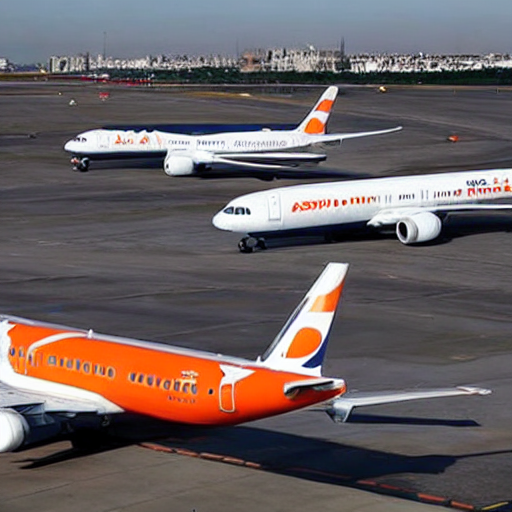

In [99]:
# Example inference
output_text, image = generateSummary(test_data_X[26], tokenizer, model, device, pipeline)
print(output_text)
image

In [130]:
test_data_X[129]

'(CNN)For superhero fans, the cup runneth over. Most of us know the members of the Avengers by now: Iron Man, Captain America, Hulk and the rest, and the fact that a few more like Quicksilver are joining the cast in the "Avengers: Age of Ultron" sequel. But there was one character who remained a mystery: the Vision, to be played by Paul Bettany. Thus far, we\'ve only seen his eyes in a trailer. With less than a month to go before the movie hits theaters, Marvel Studios put all the speculation to rest with a poster featuring Bettany as the heroic android, who was a member of the superhero group for many years in the comics. Meanwhile, as many Marvel fans know, Thursday was the eve of the new Netflix series "Daredevil," and after a photoshopped first look at Charlie Cox\'s iconic red Daredevil suit went out, Marvel put out a video of the real one. Not to be outdone, director Bryan Singer announced a new character for next year\'s sequel "X-Men: Apocalypse," by telling Empire magazine tha

  0%|          | 0/50 [00:00<?, ?it/s]

"Daredevil" is coming to theaters on january 7.


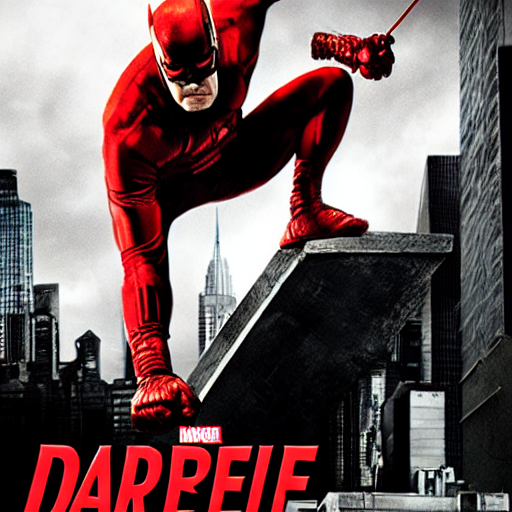

In [131]:
# Example inference
output_text, image = generateSummary(test_data_X[129], tokenizer, model, device, pipeline)
print(output_text)
image